In [114]:
import zarr
import s3fs
#import fastfuels
import fastfuelsUpdated
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import ipyparams
import ckanapi

In [110]:
# get ckan resource id from jupyter url
r = ipyparams.params['r']
r

In [111]:
# remote ckan api
ckan = ckanapi.RemoteCKAN('https://pulaski.sdsc.edu:5000')

In [113]:
# get data url from resource id
resource = ckan.action.resource_show(id=r)
url = resource['url']
url

In [2]:
s3 = s3fs.S3FileSystem(client_kwargs={
                        "endpoint_url": url,
                        "verify": False
                       },
                       username="",
                       password="")



In [3]:
store = s3fs.S3Map(root='/ca.fio', s3=s3, check=False)
z = zarr.group(store=store)

In [125]:
z['surface']['sav'].shape

(1213200, 714930)

In [6]:
#print(z.tree(level=1))

### convert from lat/long coords to indices of fuel array data

In [117]:
def coordinates_to_indices(lat1,lon1,lat2,lon2):
    
    """
    inputs: takes in lat/lon coordinates
    outputs: fuel array indices
    """

    # Performs forward projection from geodetic coordinates to projected coordinates

    A=fastfuelsUpdated.AlbersEqualAreaConic()

    x1, y1 = A.forward(lat1, lon1)
    x2, y2 = A.forward(lat2, lon2)



    #get extent

    extent_x1, extent_y1, extent_x2, extent_y2 = z.attrs['extent']

    # calculate indices of fuel array

    x1_rel = int(x1 - extent_x1)
    y1_rel = int(extent_y1 - y1)
    x2_rel = int(x2 - extent_x1)
    y2_rel = int(extent_y1 - y2)

    return x1_rel,y1_rel, x2_rel,y2_rel

# generate data for 3 regions - lake tahoe, Blodgett Forest (near Lake Tahoe), Elfin Forest (San Diego) 

In [121]:
# choose location near lake tahoe
lon1 = -120.21303
lat1 = 39.21391

lon2 = -120.1926
lat2 = 39.20831

# convert coordinates
x1_rel,y1_rel, x2_rel,y2_rel = coordinates_to_indices(lat1,lon1,lat2,lon2)

# get data array for that region
data_lake_tahoe = z['surface']['sav'][y1_rel:y2_rel, x1_rel:x2_rel]

In [122]:
# choose location in Blodgett Forest (near Lake Tahoe)
lat1 = 38.883575
lon1 = -120.65020833333334

lat2 = 38.86849
lon2 = -120.63286

# convert coordinates
x1_rel,y1_rel, x2_rel,y2_rel = coordinates_to_indices(lat1,lon1,lat2,lon2)

# get data array for that region
data_Blodgett = z['surface']['sav'][y1_rel:y2_rel, x1_rel:x2_rel]

In [123]:
# choose location in Elfin Forest (San Diego) 
lat1 = 33.07029
lon1 = -117.17051

lat2 = 33.05975
lon2 = -117.15656

# convert coordinates
x1_rel,y1_rel, x2_rel,y2_rel = coordinates_to_indices(lat1,lon1,lat2,lon2)

# get data array for that region
data_Elfin = z['surface']['sav'][y1_rel:y2_rel, x1_rel:x2_rel]

# visualize 3 regions

In [154]:
fig, ax = plt.subplots(1,3,figsize=(14,10))

ax[0].imshow(data_Blodgett, cmap='rainbow', origin="lower")
ax[0].set_title('Blodgett forest (Lake Tahoe region) ')

ax[1].imshow(data_Elfin, cmap='rainbow', origin="lower")
ax[1].set_title('Elfin forest (San Diego region)')

ax[2].imshow(data_lake_tahoe, cmap='rainbow', origin="lower")
ax[2].set_title('lake_tahoe (east of Blodgett)')

fig.suptitle("Comparing 2 regions in terms of surface level, surface-area-to-volume (SAV) fastfuels data", fontsize=14);

## cluster analysis using kmeans approach

In [ ]:
# Key questions of interest - 
# How to best deploy resources for prescribed burn land management?  
# How many different buckets does terrain vegetation fall into?
# How would you approach deploying resources in different forests?


# In this example, let's compare Blodget and Elfin Forest in terms of number of buckets vegetation falls into by clustering analysis
# Here we'll think about the data as an image and cluster different regions of the image

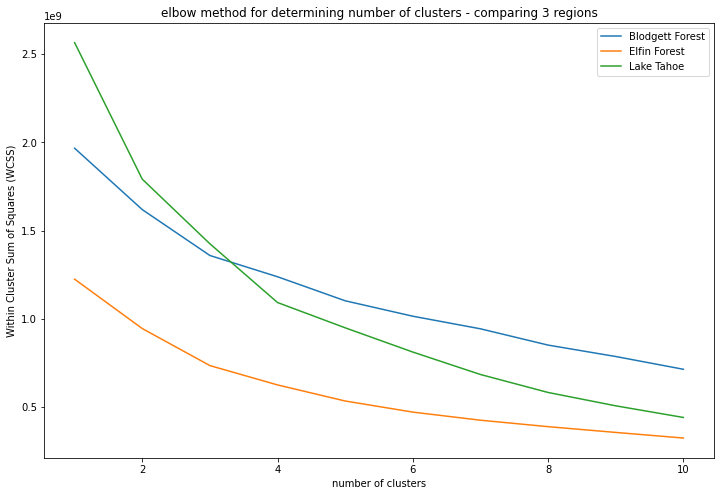

In [156]:
# Using the elbow method to find the optimal number of clusters
#  Find "crook of elbow" looking at Within-Cluster-Sum-of-Squares (WCSS) metric
# in this case, it looks like n_clusters = 4


wcss_Blodget = []
wcss_Elfin = []
wcss_Tahoe = []

for i in range(1,11):
    kmeans_Blodget = KMeans(n_clusters = i)
    kmeans_Blodget.fit(data_Blodgett)
    wcss_Blodget.append(kmeans_Blodget.inertia_)
    
    kmeans_Elfin = KMeans(n_clusters = i)
    kmeans_Elfin.fit(data_Elfin)
    wcss_Elfin.append(kmeans_Elfin.inertia_)
    
    kmeans_Tahoe = KMeans(n_clusters = i)
    kmeans_Tahoe.fit(data_lake_tahoe)
    wcss_Tahoe.append(kmeans_Tahoe.inertia_)
    
    
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(range(1,11), wcss_Blodget, label="Blodgett Forest")
ax.plot(range(1,11), wcss_Elfin, label="Elfin Forest")
ax.plot(range(1,11), wcss_Tahoe, label="Lake Tahoe")

ax.set_title('elbow method for determining number of clusters - comparing 3 regions')
ax.set_xlabel('number of clusters')
ax.set_ylabel('Within Cluster Sum of Squares (WCSS)')
ax.legend();


In [157]:
# Blodgett and Elfin (n_clusters=3) and Lake Tahoe (n_clusters=4)

# classify vegetation surface-area-to-volume into different number of clusters

kmeans_Blodget = KMeans(n_clusters = 3)
kmeans_Blodget.fit(data_Blodgett)
cluster_centers_Blodget = kmeans_Blodget.cluster_centers_
cluster_labels_Blodget = kmeans_Blodget.labels_
    
kmeans_Elfin = KMeans(n_clusters = 3)
kmeans_Elfin.fit(data_Elfin)
cluster_centers_Elfin = kmeans_Elfin.cluster_centers_
cluster_labels_Elfin = kmeans_Elfin.labels_
    
kmeans_Tahoe = KMeans(n_clusters = 4)
kmeans_Tahoe.fit(data_lake_tahoe)
cluster_centers_Tahoe = kmeans_Tahoe.cluster_centers_
cluster_labels_Tahoe = kmeans_Tahoe.labels_

In [169]:
# visualize data - images re-colored to emphasize clusters

fig,ax=plt.subplots(1,3,figsize=(14,10))
#plt.figure(figsize = (15,8))
ax[0].imshow(cluster_centers_Blodget[cluster_labels_Blodget], origin="lower")
ax[1].imshow(cluster_centers_Elfin[cluster_labels_Elfin], origin="lower")
ax[2].imshow(cluster_centers_Tahoe[cluster_labels_Tahoe], origin="lower");

In [168]:
fig, ax = plt.subplots(2,3,figsize=(14,10))

ax[0,0].imshow(data_Blodgett, cmap='rainbow', origin="lower")
ax[1,0].imshow(cluster_centers_Blodget[cluster_labels_Blodget], origin="lower")
ax[0,0].set_title('Blodgett forest (Lake Tahoe region) ')
ax[1,0].set_title('clustered (n=3) ')

ax[0,1].imshow(data_Elfin, cmap='rainbow', origin="lower")
ax[1,1].imshow(cluster_centers_Elfin[cluster_labels_Elfin], origin="lower")
ax[0,1].set_title('Elfin forest (San Diego region)')
ax[1,1].set_title('clustered (n=3) ')

ax[0,2].imshow(data_lake_tahoe, cmap='rainbow', origin="lower")
ax[1,2].imshow(cluster_centers_Tahoe[cluster_labels_Tahoe], origin="lower")
ax[0,2].set_title('lake_tahoe (east of Blodgett)')
ax[1,2].set_title('clustered (n=4) ')

fig.suptitle("Comparing 3 regions in terms of surface level, surface-area-to-volume (SAV) fastfuels data", fontsize=14);

In [8]:
# index into zarr group (3d canopy surface-area-to-volume) and get array

data = z['canopy']['sav'][y1_rel:y2_rel, x1_rel:x2_rel, :]
data

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0, 114,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0

## visualize 3d canopy surface-area-to-volume data

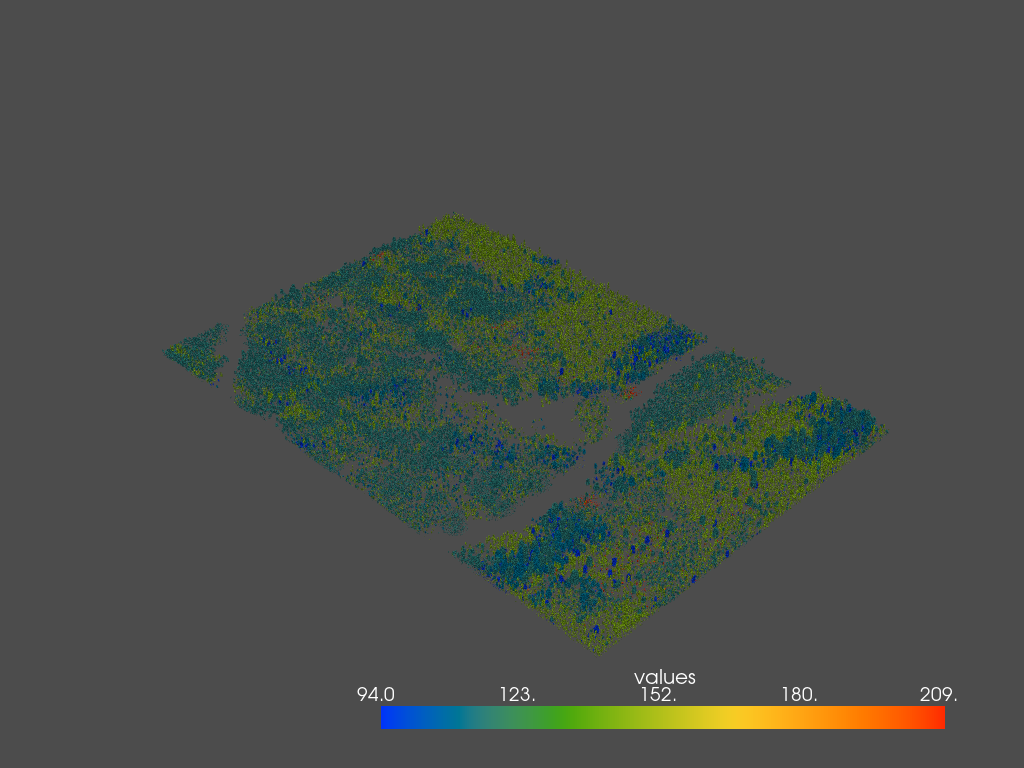

[(2596.2783969479997, 2838.7783969479997, 2102.2783969479997),
 (524.0, 766.5, 30.0),
 (0.0, 0.0, 1.0)]

In [70]:
plotter = pv.Plotter(title='FastFuels')


# move zeros to -1 for thresholding
data[data == 0] = -1

# convert the 3D array to a Pyvista UniformGrid
grid = pv.UniformGrid()
grid.dimensions = np.array(data.shape) + 1
grid.spacing = [1,1,1]
grid.cell_arrays['values'] = data.flatten(order='F')
grid = grid.threshold(0)

# conditionally select the colormap based on property
#if property == 'species_group':
#    cm = colorcet.glasbey[:10]
#else:
#    cm = 'rainbow'

# add the array to the plotter instance
plotter.add_mesh(grid, cmap='rainbow')

         
# display an interactive window populated will a 3D array       

plotter.show()

## examine 2d surface surface-area-to-volume (sav)

In [38]:
# index into zarr group (surface surface-area-to-volume) and get array

data_2d = z['surface']['sav'][y1_rel:y2_rel, x1_rel:x2_rel]
data_2d

array([[128, 128, 128, ..., 202, 202, 202],
       [128, 128, 128, ..., 202, 202, 202],
       [128, 128, 128, ..., 202, 202, 202],
       ...,
       [159, 159, 158, ..., 129, 129, 129],
       [158, 158, 157, ..., 129, 129, 129],
       [157, 157, 157, ..., 129, 129, 129]], dtype=int16)

In [52]:
data_2d.shape

(1048, 1533)

## visualize 2d data (surface level surface-area-to-volume)

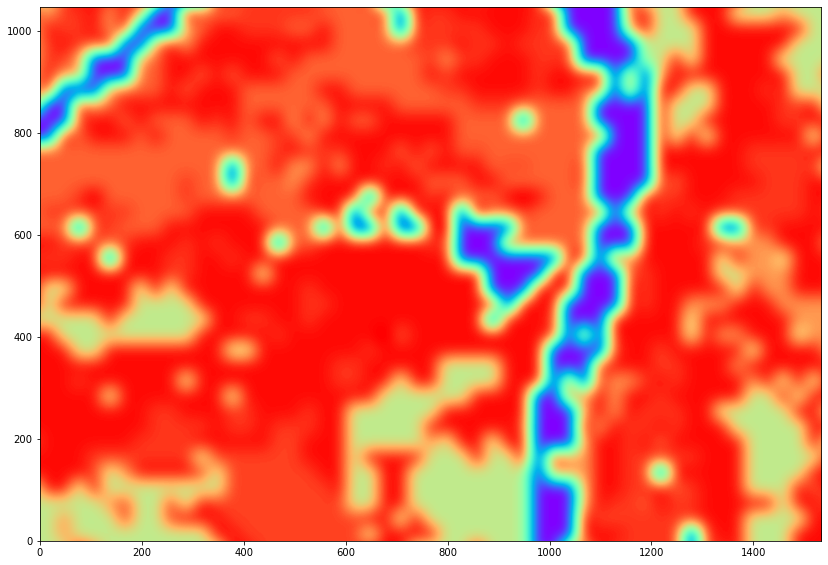

In [103]:
fig, ax = plt.subplots(figsize=(14,10))

ax.imshow(data_2d, cmap='rainbow', origin="lower");

## cluster analysis using kmeans approach

In [104]:
# Key questions of interest - 
# How to best deploy resources for prescribed burn land management?  
# How many different buckets does terrain vegetation fall into?


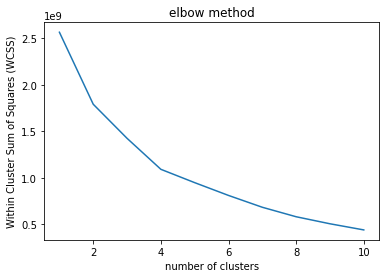

In [102]:
# Using the elbow method to find the optimal number of clusters
#  Find "crook of elbow" looking at Within-Cluster-Sum-of-Squares (WCSS) metric
# in this case, it looks like n_clusters = 4


wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(data_2d)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('elbow method')
plt.xlabel('number of clusters')
plt.ylabel('Within Cluster Sum of Squares (WCSS)')
plt.show()

In [97]:
# classify vegetation surface-area-to-volume into 4 different groups

kmeans_cluster = KMeans(n_clusters=4)
kmeans_cluster.fit(data_2d)
cluster_centers = kmeans_cluster.cluster_centers_
cluster_labels = kmeans_cluster.labels_

In [105]:
plt.figure(figsize = (15,8))
plt.imshow(cluster_centers[cluster_labels], origin="lower");

In [116]:
"""
Blodgett Forest
38* 53' 08.87" N  120* 39' 00.75"

conversion to decimal
Decimal degrees = Degrees + (Minutes/60) + (Seconds/3600)

38 + (53/60) + (0.87/3600) = 38.883575 N
120 + (39/60) + (00.75/3600) = -120.65020833333334

"""

lat1 = 38.883575
lon1 = -120.65020833333334

lat2 = 38.86849
lon2 = -120.63286




120.65020833333334